In [ ]:
#!pip install qiskit
#!pip install qiskit_finance
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution

In [ ]:
# Since we're still modelling the same underlying with the same spot price,
# we use the same probability loading

num_uncertainty_qubits = 3

spot = 3.0
vol = 0.2 #volatility
rate = 0.05 #annual interest rate
T = 100 / 365 #100 days until expiry

# returns are log-normally distributed, values relating to this distribution shown here

mu = (rate - 0.5 * vol ** 2) * T + np.log(spot)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma ** 2 / 2)
variance = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
stddev = np.sqrt(variance)

# setting the lowest and highest values considered by our model
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# loading the option's probability distribution onto the quantum computer
uncertainty_model = LogNormalDistribution(
    num_uncertainty_qubits, mu=mu, sigma=sigma ** 2, bounds=(low, high)
)

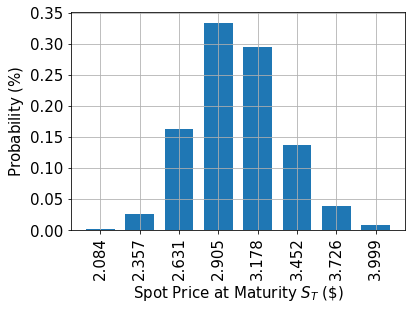

In [ ]:
# visualize the encoded probability distribution on the quantum computer
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel("Spot Price at Maturity $S_T$ (\$)", size=15)
plt.ylabel("Probability ($\%$)", size=15)
plt.show()

In [ ]:
# Now that we're using a put option,
# we compute the payoff if the function falls below the strike

# set the strike price
strike_price = 3.40

# scalar that determines accuracy of final output
# the lower the better
rescaling_factor = 0.25

# setup piecewise linear function that only pays
# if price falls below our strike

breakpoints = [low, strike_price]
slopes = [-1, 0]
offsets = [strike_price - low, 0]
f_min = 0
f_max = strike_price - low
european_put_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=rescaling_factor,
)

european_put = european_put_objective.compose(uncertainty_model, front=True)




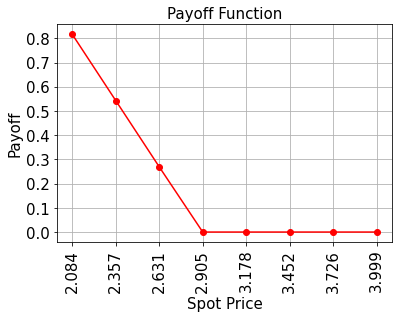

In [ ]:
# visualize the behaviour of the payoff function

x = uncertainty_model.values
y = np.maximum(0, strike_price - x)
plt.plot(x, y, "ro-")
plt.grid()
plt.title("Payoff Function", size=15)
plt.xlabel("Spot Price", size=15)
plt.ylabel("Payoff", size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [ ]:
# find the exact expected value of the option classically
exact_value = np.dot(uncertainty_model.probabilities, y)
print("exact expected value:\t%.4f" % exact_value)


exact expected value:	0.0588


In [ ]:
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = EstimationProblem(
    state_preparation=european_put,
    objective_qubits=[num_uncertainty_qubits],
    post_processing=european_put_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

In [ ]:
result = ae.estimate(problem)

In [ ]:
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:        \t%.4f" % exact_value)
print("Estimated value:    \t%.4f" % (result.estimation_processed))
print("Confidence interval:\t[%.4f, %.4f]" % tuple(conf_int))

Exact value:        	0.0588
Estimated value:    	0.0672
Confidence interval:	[0.0615, 0.0730]
